In [ ]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

In [2]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

### LOAD DATA

In [3]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

In [4]:
ABIDE_data = np.load(dataFnOut)['data']
#ABIDE_data = np.load('/mmfs1/data/aglinska/3d_grassy_mnist/fake_abide.npy')
df = pd.read_csv(dfFnOut)

In [5]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [6]:
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

### LOAD NETWORK WEIGHTS

In [7]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [8]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
fn = 'Feb04_0524_D16B1G100_DTrue'

#fn = os.path.join(fdir,fn)
fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
#fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb26_1330_forPaperFakeAbide'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

### CHECK NETWORKS

In [9]:
sfari_td_batch = SFARI_data[sfari_subs_td,:,:,:][0:15,:,:,:]
sfari_dupl_batch = SFARI_data[sfari_subs_dupl,:,:,:][0:15,:,:,:]
sfari_del_batch = SFARI_data[sfari_subs_del,:,:,:][0:15,:,:,:]

asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

In [10]:
def cvae_predict(im_in,idx=1):
    # 0 for ASD, 1 for TD
    #im_in = [DX_batch,TD_batch][idx]
    _zeros = np.zeros(s_encoder(im_in)[2].shape)

    v = 2
    cvae_sal_vec = np.hstack((_zeros,s_encoder(im_in)[v]))
    cvae_bg_vec = np.hstack((z_encoder(im_in)[v],_zeros))

    if idx==1:
        cvae_full_vec = np.hstack((z_encoder(im_in)[v],s_encoder(im_in)[v]))
    elif idx==0:
        cvae_full_vec = cvae_bg_vec
        
    out = cvae_decoder.predict(cvae_full_vec)
    
    return out[:,:,:,:,0]

Text(0, 0.5, 'MSE')

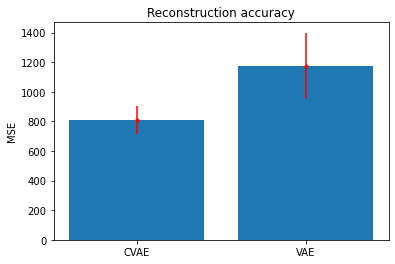

In [11]:
asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)

matIn = DX_batch
n = matIn.shape[0]

vae_out = decoder.predict(encoder(matIn)[2])[:,:,:,:,0]
cvae_out = cvae_predict(matIn,idx=1)

vae_resid = (matIn-vae_out)**2
cvae_resid = (matIn-cvae_out)**2

vae_acc = np.array([vae_resid[i,:,:,:].sum() for i in range(n)])
cvae_acc = np.array([cvae_resid[i,:,:,:].sum() for i in range(n)])

xs = [0,1];
m = [cvae_acc.mean(),vae_acc.mean()];
se = [cvae_acc.std(),vae_acc.std()];
plt.bar(xs,m);
plt.errorbar(xs,m,se,fmt='r.');
plt.xticks(xs,labels=['CVAE','VAE']);
plt.title('Reconstruction accuracy')
plt.ylabel('MSE')

### ^VAE is a bit worse at reconstruction overall. This needs to be fixed. For these analyses here it doesnt matter much because the reconstructions are still fairly ok. And also - we're mostly interested in the difference between BG and SL space

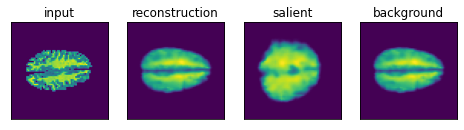

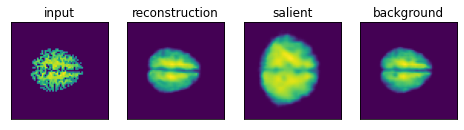

In [12]:
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0) # PLOT ASD SUBJECT
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1) # PLOT TD SUBJECT

### CVAE Reconstructions look good

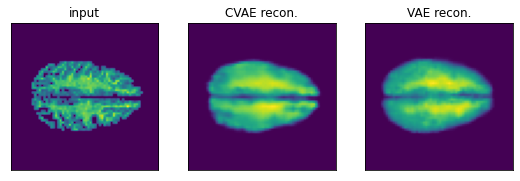

In [13]:
s = 1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1);plt.imshow(matIn[s,:,:,40]);plt.title('input');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,2);plt.imshow(cvae_out[s,:,:,40]);plt.title('CVAE recon.');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,3);plt.imshow(vae_out[s,:,:,40]);plt.title('VAE recon.');plt.xticks([]);plt.yticks([]);

### For CVAE and VAE reconstruct the brain images well

In [14]:
vae_space = dim_reduce(encoder.predict(ABIDE_data)[2])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=2, method='UMAP')

### Distributions of ASD subjects in the three spaces. Evidence of clustering in BG, SL and VAE seem random (RSA results will show how they are organized)

In [15]:
svec = s_encoder.predict(ABIDE_data)

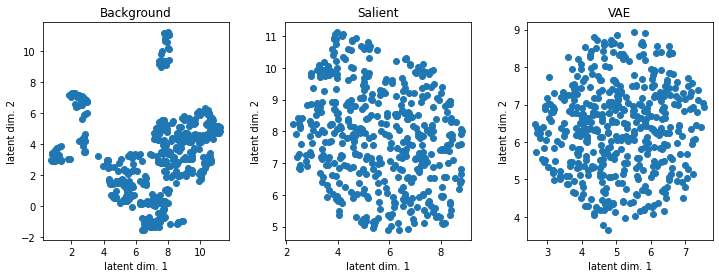

In [16]:
cscatter([bg_space,sl_space,vae_space],v=patients)

In [17]:
%%time
v = patients
rdm_bg = 1-make_RDM(bg_space[v,:],data_scale='ratio')
rdm_sl = 1-make_RDM(sl_space[v,:],data_scale='ratio')
rdm_vae = 1-make_RDM(encoder.predict(ABIDE_data)[2][v,:],data_scale='ratio')

CPU times: user 1.3 s, sys: 582 ms, total: 1.88 s
Wall time: 789 ms


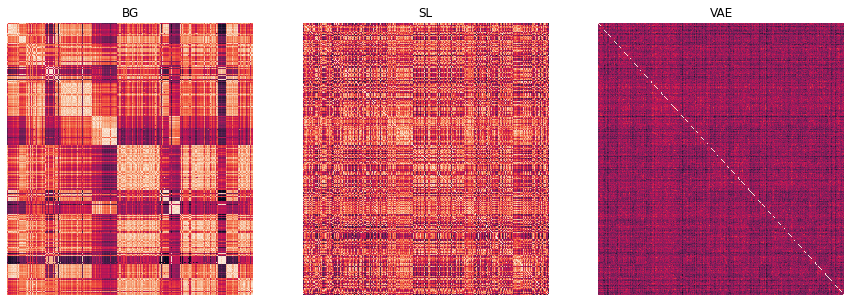

In [18]:
f, ax = plt.subplots(1,3,figsize=(15,5))
sns.heatmap(rdm_bg,cbar=[],ax=ax[0],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_sl,cbar=[],ax=ax[1],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_vae,cbar=[],ax=ax[2],xticklabels=[],yticklabels=[]);

[ax[i].set_title(['BG','SL','VAE'][i]) for i in range(3)];

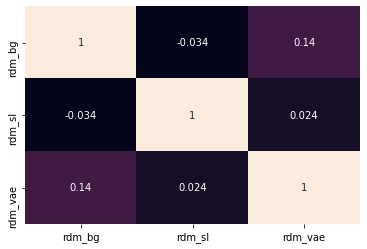

In [19]:
space_cmat = np.corrcoef(np.array([get_triu(x) for x in [rdm_bg,rdm_sl,rdm_vae]]));
lbls= ['rdm_bg','rdm_sl','rdm_vae'];
sns.heatmap(space_cmat,annot=True,cbar=[],xticklabels=lbls,yticklabels=lbls);

In [20]:
from sklearn.mixture import BayesianGaussianMixture

In [21]:
n_clust = 3
bnp = BayesianGaussianMixture(n_components=n_clust,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=1000,
    n_init=10,
    init_params='kmeans',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=None,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=None,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10)

In [22]:
cid_s = bnp.fit_predict(s_encoder.predict(ABIDE_data[patients,:,:,:])[0])
zeros = np.zeros(16)

In [23]:
out = cvae_decoder.predict(np.array([np.hstack((zeros,bnp.means_[i,:])) for i in range(n_clust)]))

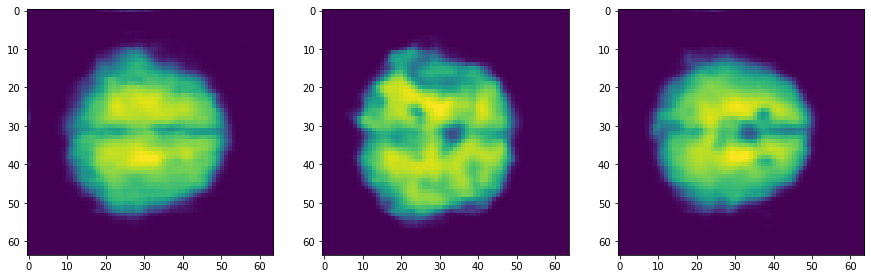

In [24]:
f, ax = plt.subplots(1,n_clust,figsize=(5*n_clust,5))
for i in range(n_clust):
    ax[i].imshow(out[i,:,:,40,:])

In [25]:
from scipy.stats import multivariate_normal
i = 1

In [26]:
mu = bnp.means_[i]
cov = np.linalg.inv(bnp.precisions_[i])

In [27]:
n_sample = 10
sampled_vec = multivariate_normal(mean=mu, cov=cov, allow_singular=False, seed=None).rvs(size=n_sample)
zeros = np.zeros(sampled_vec.shape)
imOut = cvae_decoder.predict(np.hstack((zeros,sampled_vec)))
#plt.imshow(im)

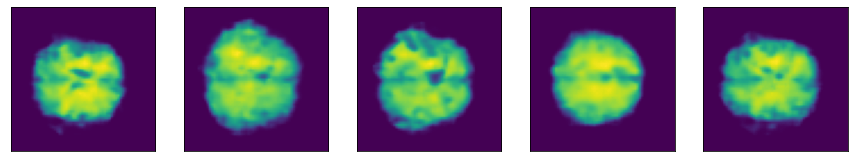

In [28]:
f,ax = plt.subplots(1,5,figsize=(15,5))
[ax[i].imshow(imOut[i,:,:,40,0]) for i in range(5)];
[a.set_xticks([]) for a in ax];
[a.set_yticks([]) for a in ax];

In [29]:
data = ABIDE_data[patients,:,:,:]
w = 0
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

<ErrorbarContainer object of 3 artists>

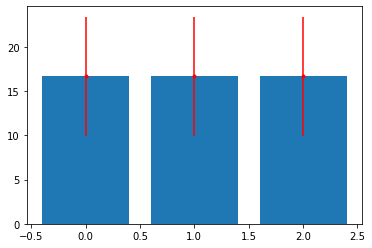

In [68]:
key = 'AgeAtScan'
vec = df[key].values
xs = np.arange(n_clust)
m = [np.nanmean(vec[np.array(np.nonzero(patients))[0,:][cid_s==2]]) for i in range(n_clust)]
se = [np.nanstd(vec[np.array(np.nonzero(patients))[0,:][cid_s==2]]) for i in range(n_clust)]

plt.bar(xs,m)
plt.errorbar(xs,m,se,fmt='r.')

In [31]:
import umap

In [32]:
s = s_encoder.predict(ABIDE_data)[2]
b = z_encoder.predict(ABIDE_data)[2]
v = encoder.predict(ABIDE_data)[2]

In [33]:
mapper = umap.UMAP(n_neighbors=15,n_components=3)

In [34]:
%%time 
s_embedding = mapper.fit_transform(s)
b_embedding = mapper.fit_transform(b)
v_embedding = mapper.fit_transform(v)

CPU times: user 2min 55s, sys: 1.62 s, total: 2min 57s
Wall time: 10.5 s


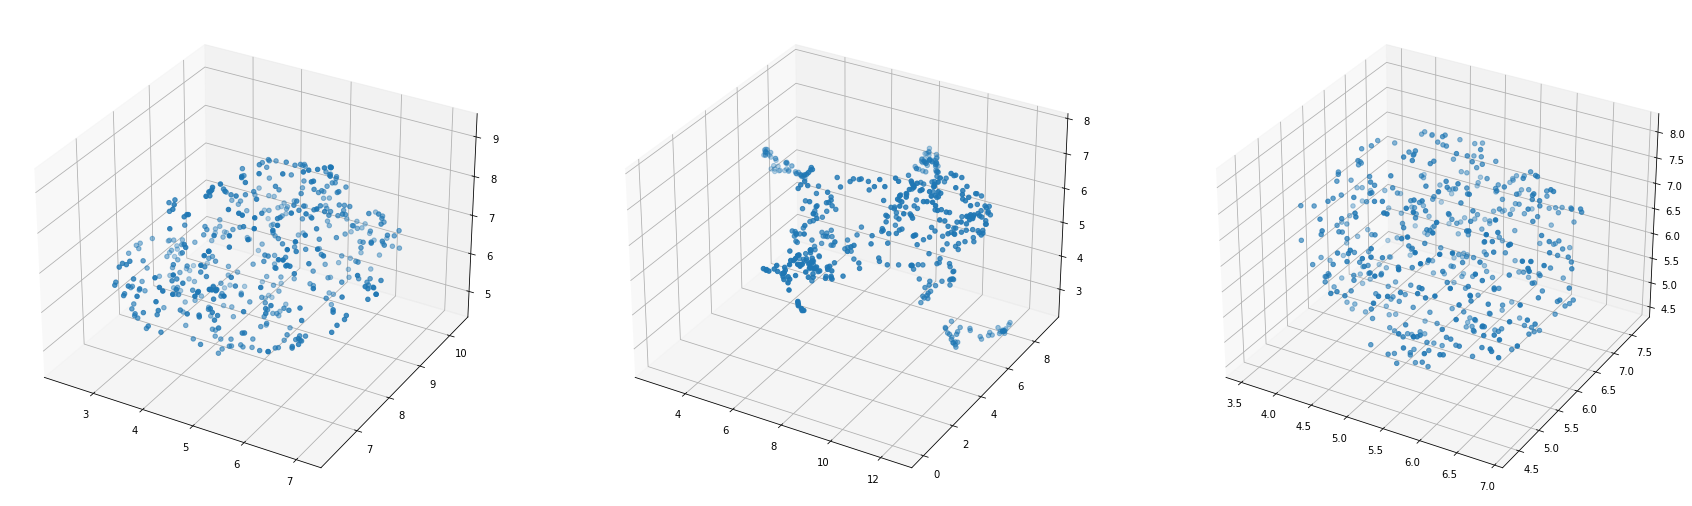

In [35]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,3,1,projection='3d')
ax.scatter(s_embedding[patients,0],s_embedding[patients,1],s_embedding[patients,2])

ax = fig.add_subplot(1,3,2,projection='3d')
ax.scatter(b_embedding[patients,0],b_embedding[patients,1],b_embedding[patients,2])

ax = fig.add_subplot(1,3,3,projection='3d')
ax.scatter(v_embedding[patients,0],v_embedding[patients,1],v_embedding[patients,2])